# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000

n_greater_50k = len([i for i in data['income'] if i == ">50K" ])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len([i for i in data['income'] if i == "<=50K" ])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100.0*n_greater_50k / len(data)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

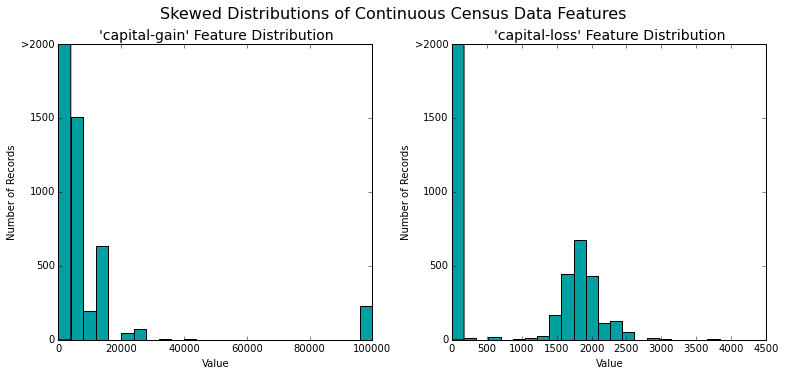

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

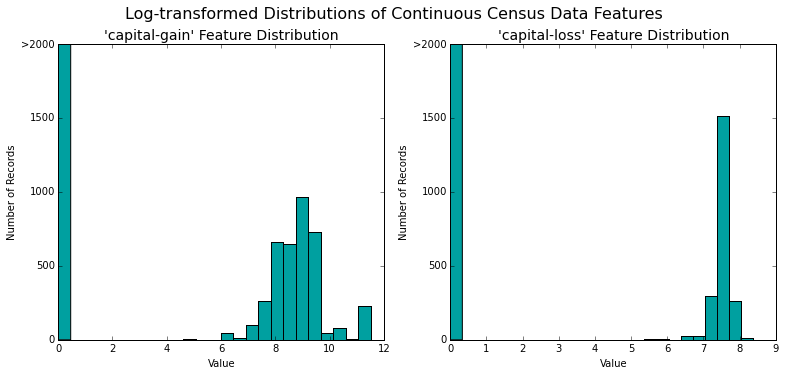

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))
# Print original for comparison
display(data.drop('income', axis = 1).head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0,0.397959,United-States


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [15]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()

print len(features_raw.columns)

features = pd.get_dummies(features_raw)

print len(features.columns)

# # TODO: Encode the 'income_raw' data to numerical values

income = pd.Series(np.zeros(len(income_raw)))
for index, income_in_word in enumerate(income_raw):
     if income_in_word == ">50K":
            income[index] = 1

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

13
103
103 total features after one-hot encoding.


### <font color='blue'>Alternative for one-hot encoding </font>   

In [18]:
income_greater_50K = pd.get_dummies(income_raw)['>50K']
income_less_than_50K = pd.get_dummies(income_raw)['<=50K']

print income_greater_50K.head(n=10)
print income_less_than_50K.head(n=10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: >50K, dtype: float64
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    0
8    0
9    0
Name: <=50K, dtype: float64


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [20]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [30]:
#
# generate accuracy using the stats calculated earlier
accuracy = greater_percent / 100.

# TODO: Calculate F-score using the formula above for beta = 0.5
precision = accuracy

recall = 1.0

input_beta = 0.5

fscore = (1 + input_beta**2) * precision * recall / (input_beta**2 * precision + recall)

print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [28]:
# TODO: Calculate accuracy
from sklearn.metrics import accuracy_score, fbeta_score

y_all_one_pred = pd.Series(np.ones(len(income)))

accuracy = accuracy_score(income, y_all_one_pred)
#print accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(income, y_all_one_pred, 0.5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** I would like to use **Gaussian Naive Bayes**, **Ensemble Methods**, and **K-Nearest Neighbors** for this project.

Google has implemented **Gaussian Naive Bayes** to [classify spam mail][Naive Bayes]. Based on the reference, the advantage is that Naive Bayes method can be trained on a per-user basis. The customized criteria are given so that the prediction becomes more reliable according to user's specific patterns. However, if a picture or a mutated word instead of a highly possible spam word is used in a mail, the model might not be able to identify the spam properly. Since we are trying to identify whether the income is above or below 50K, which is a rather straightforward classfication problem, Naive Bayes should be a suitable method.

**Ensemble methods** are very powerful techniques to increase accuracy on a variety of ML tasks. It can be used in conjunction with many other types of learning algorithms to [improve their performance][ada_boost]. For instance, AdaBoost, one of the ensemblings method, is applied commonly for object detection. General speaking, every algorithm does require some parameters to be adjusted before achieving optimal performance. Ensemble methods, on the other hand, is relatively [easy to program][boosting_paper]. One potential disadvantage is that this method is sensitive to noisy data and outliers. [Here][web_boosting] provdies a nice introduction of boosting. As indicating in [Udacity supplemantary material][intro_to_boosting], we note that "selecting an appropriate weak learner is one of the key steps towards producing a successful boosting algorithm."

**K-Nearest Neighbors (KNN)** algorithm has been implemented in versatile fields, and probably computer version is one of the most common example. Handwritting or gesture recognition can be done by comparing the input with a database. Since KNN is a non-parametric method, the decision boundary can [take on any form][KNN_quora]. KNN does better when one focusses on finding the similarity between different observations, and the dataset is small. For the problem with low dimentionality, KNN should be a good choice. On the other hand, KNN might not perform well while the dimentionality is high. Furthermore, this approach cannot identify the importance of the attribute. I feel that KNN might not be a "good" candidate for this problem, but I would like to see how it does comparing with other "better" approach.

In summary, **Gaussian Naive Bayes** can perform well while samples are independent to each other, and such approach doesn't require hyperparameter optimization. Due to high dimensionality of the dataset, **Gaussian Naive Bayes** and **Ensemble methods** are the good candicates for our problem. Both approaches can provide [fast][which_one] and robust results. And general speaking, **Ensemble methods** outperfroms single algorithm across a whole range of problems. 

[Naive Bayes]: https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering "Naive Bayes" 

[ada_boost]: https://en.wikipedia.org/wiki/AdaBoost "AdaBoost"

[boosting_paper]: https://www.cs.princeton.edu/courses/archive/spring07/cos424/papers/boosting-survey.pdf "boosting paper"

[web_boosting]: https://codesachin.wordpress.com/tag/adaboost/ "Introduction of boosting"

[intro_to_boosting]: https://storage.googleapis.com/supplemental_media/udacityu/367378584/Intro%20to%20Boosting.pdf "Intro to Boosting"

[KNN_quora]: https://www.quora.com/Classification-machine-learning-When-should-I-use-a-K-NN-classifier-over-a-Naive-Bayes-classifier "KNN vs NB"

[which_one]: https://sebastianraschka.com/faq/docs/best-ml-algo.html "which machine learning algorithms"


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [31]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
#from sklearn.utils import resample

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    
    first_300_training_samples = 300
    
    X_sample_size_train = X_train[:first_300_training_samples]
    y_sample_size_train = y_train[:first_300_training_samples]
    
    learner.fit(X_sample_size_train, y_sample_size_train)
    
    #resample(X_train, n_samples=sample_size, random_state=0)
    end = time() # Get end time
    
#     # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_sample_size_train)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_sample_size_train, predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_sample_size_train, predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
KNeighborsClassifier
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


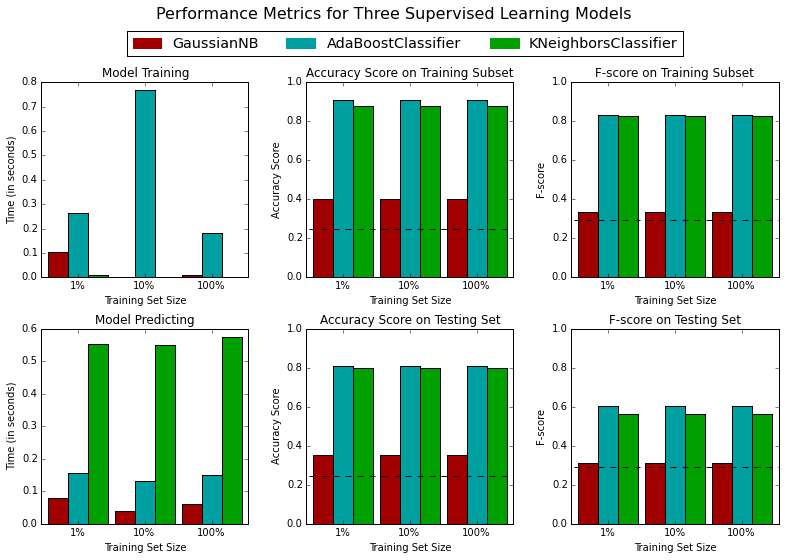

In [32]:
# TODO: Import the three supervised learning models from sklearn

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=123)
clf_C = KNeighborsClassifier(2)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_1 = int(len(y_train)*0.01)
samples_10 = int(len(y_train)*0.1)
samples_100 = len(y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
#for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    print clf_name
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        #print results[clf_name][i]
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer:** Based on the previous evaluation, I would consider AdaBoostClassifier as the best model to indentify individuals that make more than \$50,000. This can be supported by the accuracy score and F-score on Testing set that AdaBoostClassifier possesses the highest score throughout the training set size from 1%, 10%, and 100%. Even though the model using KNeighborsClassifier also have very similiar accuracy and F-  scores, it takes considerable amount of time for model predicting. 

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Ensemble Methods, or more explicitly AdaBoosting in our case, is chosen as the best method for this project. AdaBoosting, or Adaptive Boosting method can be considered as the combination of many different types of learning process (eg, classifier such as decision trees) to create an "ensemble" of predicting model whether an individual has income above 50K or not. Using features like age, sex, educational_level etc., the decision tree grows as a flowchart to answering "yes/no" question to classify the samples. A very important concept of AdaBoosting is that more attention is paid on weak classifier during training process. The idea is analogue to the learning process of someone, who is trying to memorize vocabulary words, will put more effort on those words he/she doesn't remember in previous exercises. By repeating this process up to desired amount of cycle, classifier improves the performance on their weakness. After each classifier is trained, the final predictive model consists of weighted classifiers where more accurate classifiers are given more weight, as an ensemble. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

### The discussion about good estimator for AdaBoosting  
http://stackoverflow.com/questions/18306416/adaboostclassifier-with-different-base-learners  
http://stackoverflow.com/questions/12097155/weak-classifier

In [33]:
# import inspect
# from sklearn.utils.testing import all_estimators
# for name, clf in all_estimators(type_filter='classifier'):
#     if 'sample_weight' in inspect.getargspec(clf().fit)[0]:
#        print name


# https://github.com/scikit-learn/scikit-learn/issues/6501
# One has to use non-default solver to pass the sample_weight requirement for LogisticRegression 

In [37]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the classifier
search_estimator_clf = AdaBoostClassifier(random_state=123)

parameters = {'base_estimator' : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=8)]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj_estimator = GridSearchCV(search_estimator_clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit_estimator = grid_obj_estimator.fit(X_train, y_train)

# Get the estimator
clf = grid_fit_estimator.best_estimator_

print "The best estimator are {:s}".format(grid_fit_estimator.best_params_)

The best estimator are {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


In [41]:
# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators' : [10, 100, 1000], 'learning_rate': [0.1, 1.0, 10]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_test)


# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "The best parameters are {:s}".format(grid_fit.best_params_)

Unoptimized model
------
Accuracy score on testing data: 0.8667
F-score on testing data: 0.7400

Optimized Model
------
Final accuracy score on the testing data: 0.8714
Final F-score on the testing data: 0.7531
The best parameters are {'n_estimators': 1000, 'learning_rate': 0.1}


#### Pro tip from the grader: Look at grid scores

In [44]:
from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

,parameters,mean_validation_score,cv_validation_scores
0,"{u'n_estimators': 10, u'learning_rate': 0.1}",0.702939,"[0.701762480391, 0.701460600986, 0.70559258186]"
1,"{u'n_estimators': 100, u'learning_rate': 0.1}",0.744670,"[0.741255794353, 0.742818859392, 0.749936229912]"
2,"{u'n_estimators': 1000, u'learning_rate': 0.1}",0.754145,"[0.753336852424, 0.751009216239, 0.75808806578]"
3,"{u'n_estimators': 10, u'learning_rate': 1.0}",0.717293,"[0.72158575785, 0.715450468814, 0.714841621916]"
4,"{u'n_estimators': 100, u'learning_rate': 1.0}",0.746518,"[0.742261052949, 0.745056762649, 0.752236067579]"
5,"{u'n_estimators': 1000, u'learning_rate': 1.0}",0.722069,"[0.720397864404, 0.721436343852, 0.724373745633]"
6,"{u'n_estimators': 10, u'learning_rate': 10}",0.192337,"[0.0567347961485, 0.286755604456, 0.233519205186]"
7,"{u'n_estimators': 100, u'learning_rate': 10}",0.192337,"[0.0567347961485, 0.286755604456, 0.233519205186]"
8,"{u'n_estimators': 1000, u'learning_rate': 10}",0.192337,"[0.0567347961485, 0.286755604456, 0.233519205186]"


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478               |      0.8667             |     0.8714            |
| F-score        |      0.2917               |      0.7400             |   0.7531      |


**Answer: ** The optimized model is AdaBoosting with estimator DecisionTreeClassifier(max_depth=2), learning_rate equals 0.1, and n_estimators equals 1000. The optimized model has outperformed the benchmark predictor and unoptimized model (Table above). Because we simply assume every income is greater than 50K in benchmark predictor, there is a large accuracy improvement from benchmark predictor to unoptimized model, as expected. The accuracy score is slightly improved from 86.67% to 87.14% by tunning learning_rate and n_estimators. However, there is presumably very limited domain knowledge introducing in these models, yet. So probably there is some room for improvement if domain knowledge is included.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [89]:
#display(data.columns)
display(data.head(1))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


**Answer:** Since we want to predict the income, I would rank the most important features in order as workclass, occupation, education_level, native-country, and education-num. Because the salary is closely determined by the type of job, I think workclass and occupation play a significant role here. In order to being in such occupation, education_level should be prerequisite that education-num goes above some minimal. Besides that, living standards are different at varieous countries even holding the same job, one should also consider native-country as important factor.  

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

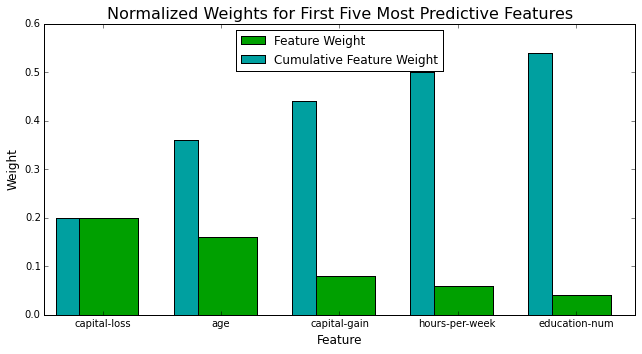

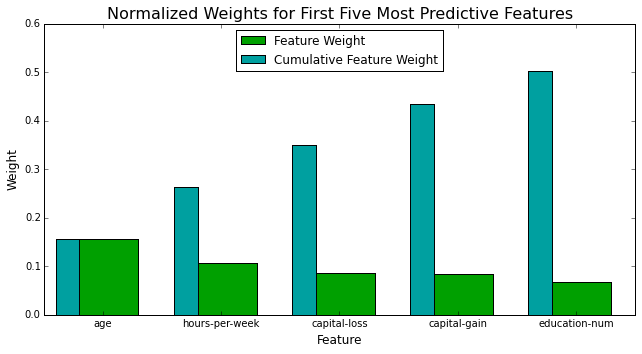

In [51]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier


# TODO: Train the supervised model on the training set 

model = AdaBoostClassifier(random_state=123)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

importances_from_optimized = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)
vs.feature_plot(importances_from_optimized, X_train, y_train)

**Note:** The ranking of feature importance are different by same classifier with various tunning parameters.

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** These five features are very different to my selected ones. While I take a look at the name of these features but not data itself, I feel capital-loss and capital-gain should be very important to determine the income becuase these two features are directly related to income. Then I glance on the data, I notice most of the capital-gain and capital-loss are equal to zero from first 100 datapoints. I remove these features from my prediction and I am surprised the model can still capture these capital_loss and capital_gain as the top-5 important factors. I believe age is also an important factor that young people is very unlikely to make more than 50K per year, but I am also surprised that it is so significant. Hours-per-week is a tricky feature, I would say. I feel it is hard to distinguish whether people make more money by working more. Lots of working poor do work a lot, but earn less though. However, I have to admit that I overestimate the importantance of educational_level, the necessity of more advanced education has been criticized. Because the data is collected from 1994 U.S. Census, it would be very interesting to compare with the census data which collect in 21 century.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [47]:
# Import functionality for cloning a model
from sklearn.base import clone

# Full feature space
start = time()
clf.fit(X_train, y_train)
end = time()

full_time = end - start

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

cloned_clf = clone(best_clf)
start = time() # Get start time
# Train on the "best" model found from grid search earlier
clf = cloned_clf.fit(X_train_reduced, y_train)
end = time() # Get end time

#     # TODO: Calculate the training time
reduced_time = end - start

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

#print full_time, reduced_time  

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8714
F-score on testing data: 0.7531

Final Model trained on reduced data
------
Accuracy on testing data: 0.8426
F-score on testing data: 0.7007


In [48]:
print "Full dataset takes {:.2f} and reduced dataset takes {:.2f} seconds.".format(full_time, reduced_time)


Full dataset takes 7.12 and reduced dataset takes 32.66 seconds.


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The accuracy and F-score on full and reduced data with only five features are decreased from 0.8714 to 0.8426 and 0.7531 to 0.7007, respectively. I would argue that the prediction with reduced dataset still perform reasonably well without sacrificing too much on accuracy. Moreover, the execution time using reduced dataset is about 7.12 seconds, which is greatly less than 32.66 seconds by full dataset. Finally, one could obtain some insightful characteristics with reduced data. As what have been addressed in feature selection section, these selective features are dominated in our prediction and provide better understanding of the model. With that, I will consider using the reduced data as my training set. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.